In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
df_hourly = pd.read_csv('Hourly power generation - Sheet1.csv', 
                 parse_dates={'datetime': ['Date', 'Time']}, 
                 infer_datetime_format=True)

In [3]:
df_hourly

,datetime,Plant Details,Generation
0,2006-12-16 00:00:00,PlantA_Unit1,120
1,2006-12-16 00:00:00,PlantA_Unit2,130
2,2006-12-16 00:00:00,PlantA_Unit3,30
3,2006-12-16 01:00:00,PlantB_Unit1,160
4,2006-12-16 01:00:00,PlantB_Unit2,50
5,2006-12-16 01:00:00,PlantB_Unit3,100
6,2006-12-16 02:00:00,PlantC_Unit1,95
7,2006-12-16 02:00:00,PlantC_Unit2,90
8,2006-12-16 02:00:00,PlantC_Unit3,85
9,2006-12-17 00:00:00,PlantA_Unit1,50


In [4]:
# Split the 'Plant Details' column into 'PlantName' and 'UnitName'
df_hourly[['PlantName', 'UnitName']] = df_hourly['Plant Details'].str.split('_', expand=True)

# Remove the original 'Plant Details' column
df_hourly = df_hourly.drop('Plant Details', axis=1)

In [5]:
df_hourly

,datetime,Generation,PlantName,UnitName
0,2006-12-16 00:00:00,120,PlantA,Unit1
1,2006-12-16 00:00:00,130,PlantA,Unit2
2,2006-12-16 00:00:00,30,PlantA,Unit3
3,2006-12-16 01:00:00,160,PlantB,Unit1
4,2006-12-16 01:00:00,50,PlantB,Unit2
5,2006-12-16 01:00:00,100,PlantB,Unit3
6,2006-12-16 02:00:00,95,PlantC,Unit1
7,2006-12-16 02:00:00,90,PlantC,Unit2
8,2006-12-16 02:00:00,85,PlantC,Unit3
9,2006-12-17 00:00:00,50,PlantA,Unit1


In [6]:
# Extract 'Date' part for grouping
df_hourly['Date_only'] = df_hourly['datetime'].dt.date

# Calculate daily generation sum for each plant
daily_generation_sum = df_hourly.groupby(['PlantName', 'Date_only'])['Generation'].sum().reset_index()

# Display the result
print(daily_generation_sum)

  PlantName   Date_only  Generation
0    PlantA  2006-12-16         280
1    PlantA  2006-12-17         250
2    PlantB  2006-12-16         310
3    PlantB  2006-12-17         120
4    PlantC  2006-12-16         270
5    PlantC  2006-12-17          45


In [7]:
# Load data
df_capacity = pd.read_csv('Daily Power capacity - Sheet1.csv')

In [8]:
df_capacity

,Date,PlantA,PlantB,PlantC
0,16/12/2006,200,150,100
1,17/12/2006,190,140,90


In [9]:
# Pivot the capacity dataframe for easier calculations
df_capacity_pivot = df_capacity.melt(id_vars='Date', var_name='PlantName', value_name='Capacity')
df_capacity_pivot['Date'] = pd.to_datetime(df_capacity_pivot['Date'], format='%d/%m/%Y').dt.date

In [10]:
df_capacity_pivot

,Date,PlantName,Capacity
0,2006-12-16,PlantA,200
1,2006-12-17,PlantA,190
2,2006-12-16,PlantB,150
3,2006-12-17,PlantB,140
4,2006-12-16,PlantC,100
5,2006-12-17,PlantC,90


In [11]:
# Merge the generation and capacity dataframes
merged_df = pd.merge(daily_generation_sum, df_capacity_pivot,  how='left', left_on=['PlantName','Date_only'], right_on = ['PlantName','Date'])

In [12]:
merged_df

,PlantName,Date_only,Generation,Date,Capacity
0,PlantA,2006-12-16,280,2006-12-16,200
1,PlantA,2006-12-17,250,2006-12-17,190
2,PlantB,2006-12-16,310,2006-12-16,150
3,PlantB,2006-12-17,120,2006-12-17,140
4,PlantC,2006-12-16,270,2006-12-16,100
5,PlantC,2006-12-17,45,2006-12-17,90


In [13]:
# Calculate the generation-to-capacity ratio
merged_df['Load_factor'] = merged_df['Generation'] / merged_df['Capacity']

In [14]:
# Create the final dataframe with the required columns
final_df = merged_df[['Date_only', 'PlantName', 'Load_factor']]

In [15]:
final_df

,Date_only,PlantName,Load_factor
0,2006-12-16,PlantA,1.400000
1,2006-12-17,PlantA,1.315789
2,2006-12-16,PlantB,2.066667
3,2006-12-17,PlantB,0.857143
4,2006-12-16,PlantC,2.700000
5,2006-12-17,PlantC,0.500000


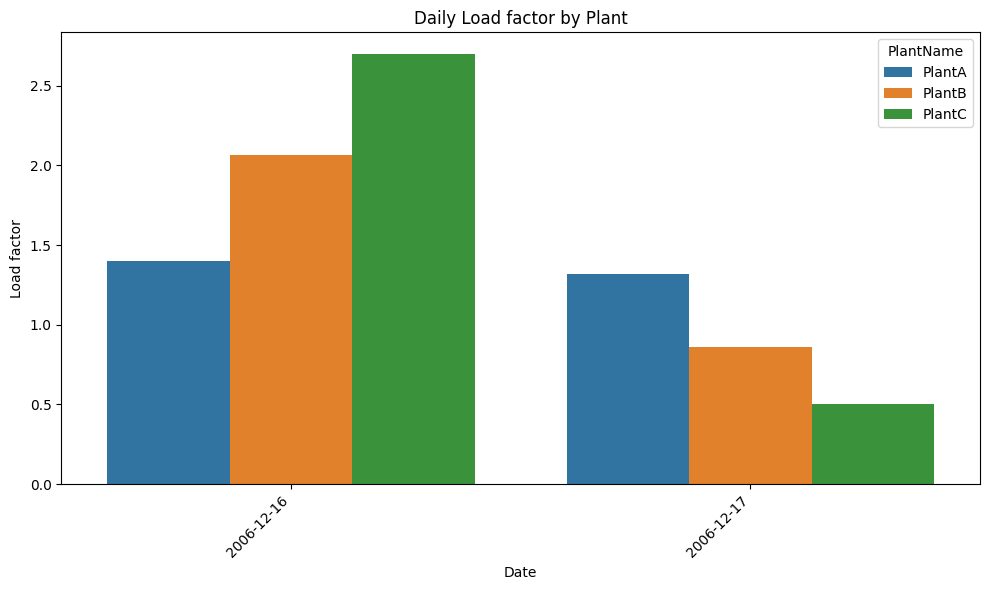

In [16]:
# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
sns.barplot(x='Date_only', y='Load_factor', hue='PlantName', data=final_df)
plt.title('Daily Load factor by Plant')
plt.xlabel('Date')
plt.ylabel('Load factor')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [17]:
final_df

,Date_only,PlantName,Load_factor
0,2006-12-16,PlantA,1.400000
1,2006-12-17,PlantA,1.315789
2,2006-12-16,PlantB,2.066667
3,2006-12-17,PlantB,0.857143
4,2006-12-16,PlantC,2.700000
5,2006-12-17,PlantC,0.500000


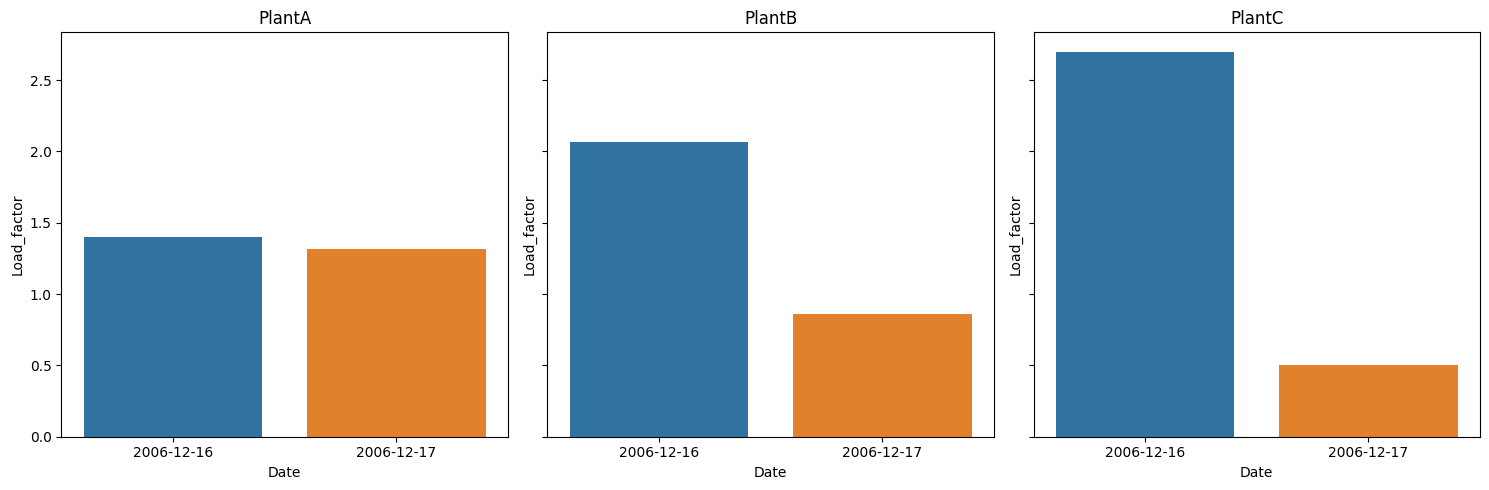

In [18]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, len(final_df['PlantName'].unique()), figsize=(15, 5), sharey=True)

# Loop through each plant and create a bar plot
for i, plant in enumerate(final_df['PlantName'].unique()):
    plant_data = final_df[final_df['PlantName'] == plant]
    ax = axes[i]  # Select the current subplot
    sns.barplot(x='Date_only', y='Load_factor', data=plant_data, ax=ax)
    ax.set_title(plant)
    ax.set_xlabel('Date')
    ax.set_ylabel('Load_factor')
    

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()